In [1]:
import pandas as pd 
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker 
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering, _agglomerative, HDBSCAN, SpectralClustering
from sklearn_extra.cluster import KMedoids
from sklearn.manifold import MDS
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score 

plt.style.use('sciencemod.mplstyle')
directories = ['deep_recycle', 'deep_dropout', 'shallow_recycle', 'shallow_dropout']
labels = {'deep_recycle': 'Deep MSA + Recycle', 'deep_dropout': 'Deep MSA + Dropout', 'shallow_recycle': 'Shallow MSA + Recycle', 'shallow_dropout': 'Shallow MSA + Dropout' }
palette = sns.color_palette().as_hex()[0:4] 
colors = {'deep_recycle': palette[0], 'deep_dropout': palette[1], 'shallow_recycle': palette[2], 'shallow_dropout': palette[3]}
save_dir = './images/'

### Utilities

In [2]:
def load_bundle() -> tuple[np.ndarray, np.ndarray]:
    data = np.load('./results/rmsd_matrix_all.npy', allow_pickle=True)
    ids = np.load('./results/ids_rmsd_matrix_all.npy', allow_pickle=True)
    return (data, ids)


def load_data(variable: str = 'rmsd_matrix') -> tuple[np.ndarray, np.ndarray]: 
    data = {}
    file_ids = {} 
    for directory in directories: 
        data[directory] = np.load(f'./results/{directory}/{variable}.npy', allow_pickle=True)
        file_ids[directory] = np.load(f'./results/{directory}/{"ids_" + variable}.npy', allow_pickle=True)
    return (data, file_ids)

## Clustering

### Agglomerative clustering 
A hierarchical clustering method with a bottoms-up approach that does not require Euclidean space, and takes in the distance matrix directly using the 'precomputed' option


In [ ]:
def plot_dendrogram(model: _agglomerative.AgglomerativeClustering, **kwargs):
    """
    Plotting function taken directly from sklearn docs
    """
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

def get_medoid(cluster_model: _agglomerative.AgglomerativeClustering, X: np.ndarray, ids: np.ndarray) -> pd.DataFrame:
    """
    Get the medoid of a cluster (sum of distances to other objects in the cluster is minimal).
    """
    # Get the indices of the points in the cluster
    labels = cluster_model.labels_
    # Cluster labels 
    clusters = np.unique(labels)
    num_clusters = len(clusters)
    medoid_indices = np.zeros(num_clusters, dtype=int)

    for c in clusters:
        # Indices of the points belonging to a given cluster "c"
        idx = np.where(labels == c)[0]
        # extract submatrix involving only the elements of the cluster
        if X.shape[0] != X.shape[1]:
            submatrix = X[idx]
        else: 
            submatrix = X[np.ix_(idx, idx)]
        sum_dist = submatrix.sum(axis=1) # column-wise sum of distances
        # Point with the smallest sum of distances is the medoid
        medoid = idx[np.argmin(sum_dist)]
        medoid_indices[c] = medoid
    # Return dataframe 
    df = pd.DataFrame({'cluster': clusters, 'index': medoid_indices, 'medoid': ids[medoid_indices]})
    return df

def plot_clusters(X: np.ndarray, labels: np.ndarray, centers: np.ndarray | None = None):
    """Plots the clusters using 2D space (requires some dimensionality reduction prior)"""
    _, ax = plt.subplots(clear=True)
    # Scatter plot 
    colors = ['#69b34f', '#efe12d', '#c858a4', '#f59797', '#87bdc0']
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels, palette=colors, alpha=0.6, legend=False, ax=ax)
    # Draw white circles at cluster centers
    if centers is not None:
        ax.scatter(centers[:, 0], centers[:, 1], marker="o", c="white", alpha=1, s=200, edgecolor="k")
        for i, c in enumerate(centers):
            ax.scatter(c[0], c[1], marker=f"${i}$", alpha=1, s=50, edgecolor="k")

    ax.set_xlabel('Coordinate 1')
    ax.set_ylabel('Coordinate 2')
    return ax 

def find_optimal_k_silhouette(X: np.ndarray, model, max_clusters: int | None = None, model_name: str = 'kmeans', verbose=True, **kwargs) -> tuple[int, np.ndarray]:
    """
    Find the optimal number of clusters for KMeans clustering.
    """
    if max_clusters is None:
        max_clusters = np.arange(3, len(X)//10 + 1)
    else: 
        max_clusters = np.arange(3, max_clusters + 1)
    savgs = np.zeros_like(max_clusters, dtype=float)
    for i, n_clusters in enumerate(max_clusters):
        if model_name == 'hdbscan':
            clustering = model(min_cluster_size=n_clusters, **kwargs)
        else: 
            clustering = model(n_clusters=n_clusters, **kwargs)
        clustering.fit(X.copy())
        labels = clustering.labels_
        if X.shape[0] != X.shape[1] or any(np.diag(X) != 0):
            # If the input is not a square matrix, compute silhouette with euclidean 
            silhouette_avg = silhouette_score(X, labels, metric='euclidean')
        else:
            # X is a distance matrix
            silhouette_avg = silhouette_score(X, labels, metric='precomputed')
        savgs[i] = silhouette_avg
        if verbose:
            print(f"For n_clusters = {n_clusters}, the silhouette score is: {silhouette_avg}")
    # Optimum number of clusters is the one with the maximum silhouette score
    optimal_k = max_clusters[np.argmax(savgs)]
    if verbose:
        print(f"Optimal number of clusters: {optimal_k}")
    return optimal_k, savgs


#### Determining number of clusters based on the the silhouette score

In [6]:
# Create a new DataFrame to store clustering results, or load existing one
load_results = False
if not load_results:
    cluster_results = pd.DataFrame(columns=['model', 'mds', 'optimal_k', 'ss', 'db', 'ch']) 
else: 
    cluster_results = pd.read_csv('./results/cluster_results.csv')  

##### No dimensionality reduction and precomputed distance matrix

11


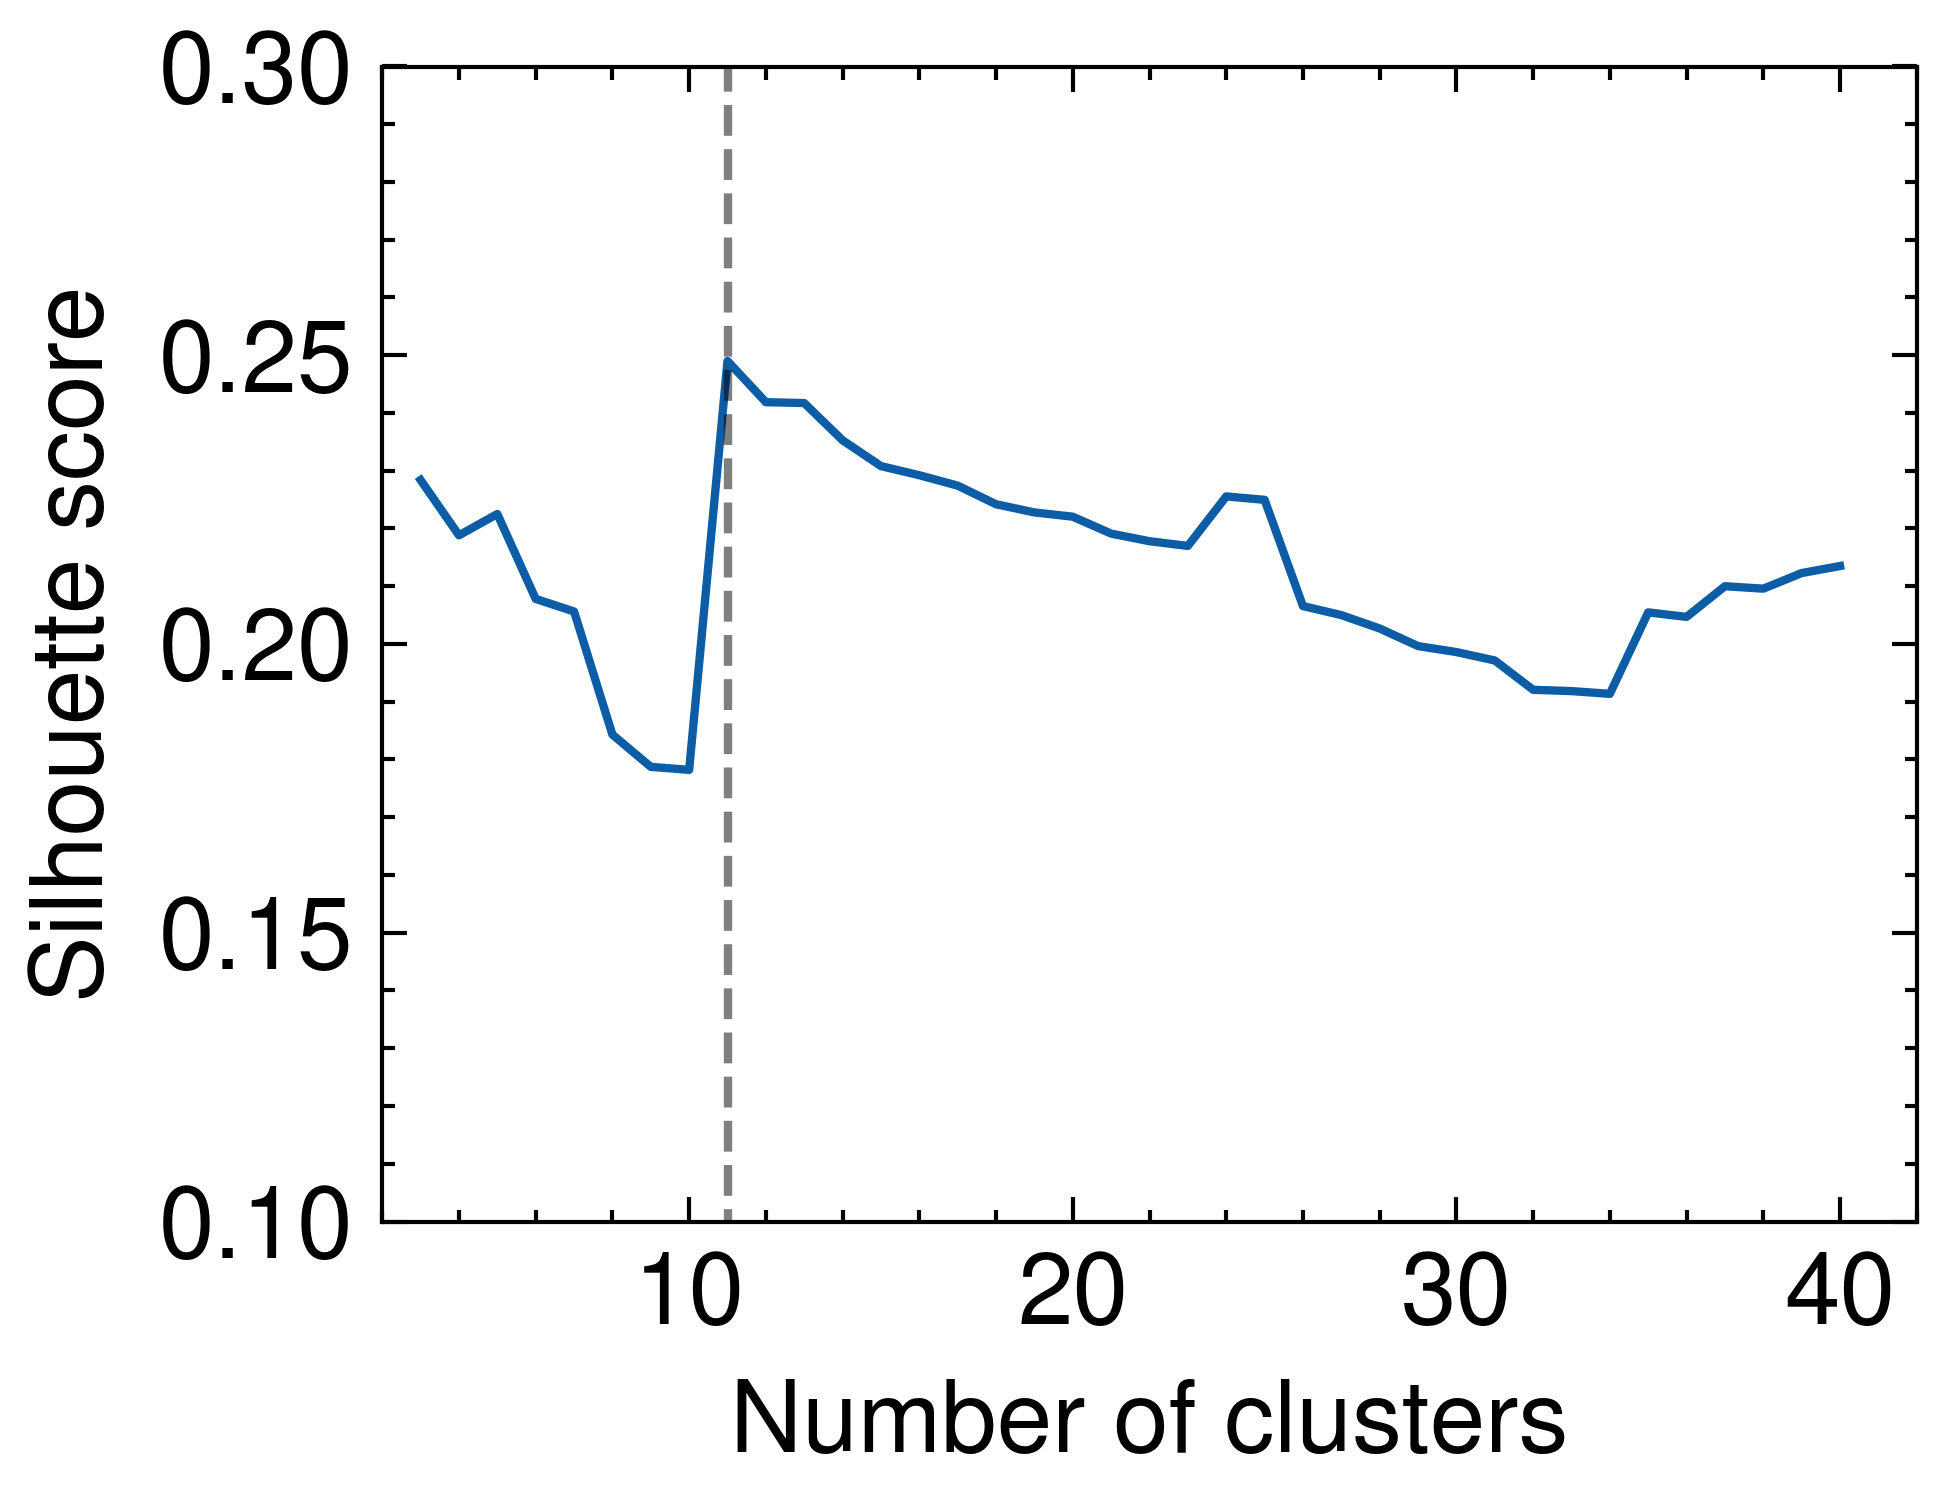

In [8]:
D, ids = load_bundle()
fig, ax = plt.subplots(clear=True)
max_clusters = 40
optimal_k, silhouette = find_optimal_k_silhouette(D, AgglomerativeClustering, max_clusters=max_clusters, model_name='Agglomerative', verbose=False, metric='precomputed', linkage='average')
sns.lineplot(x=np.arange(3, max_clusters + 1), y=silhouette, ax=ax)
ax.plot([optimal_k, optimal_k], [0, 1], linestyle='--', color='black', alpha=0.5)
ax.set_ylim([0.1, 0.3])
ax.set_xlim([2, max_clusters + 2])
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Silhouette score')
print(optimal_k)

In [10]:
aggl = AgglomerativeClustering(n_clusters=optimal_k, metric='precomputed', linkage='average', compute_distances=True)
aggl.fit(D)
cluster_results.loc[0] = ['Agglomerative', False, optimal_k, np.max(silhouette), davies_bouldin_score(D, aggl.labels_), calinski_harabasz_score(D, aggl.labels_)]
print(cluster_results)

           model    mds  optimal_k        ss        db          ch
0  Agglomerative  False         11  0.249003  1.275258  433.649021


##### With dimensionality reduction

In [11]:
# Bundled ensembles
D, ids = load_bundle()
max_clusters = 40
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42, n_jobs=-1)
X = mds.fit_transform(D)
optimal_k, silhouette = find_optimal_k_silhouette(X, AgglomerativeClustering, max_clusters=max_clusters, model_name='Agglomerative', verbose=False, metric='euclidean', linkage='average')

6


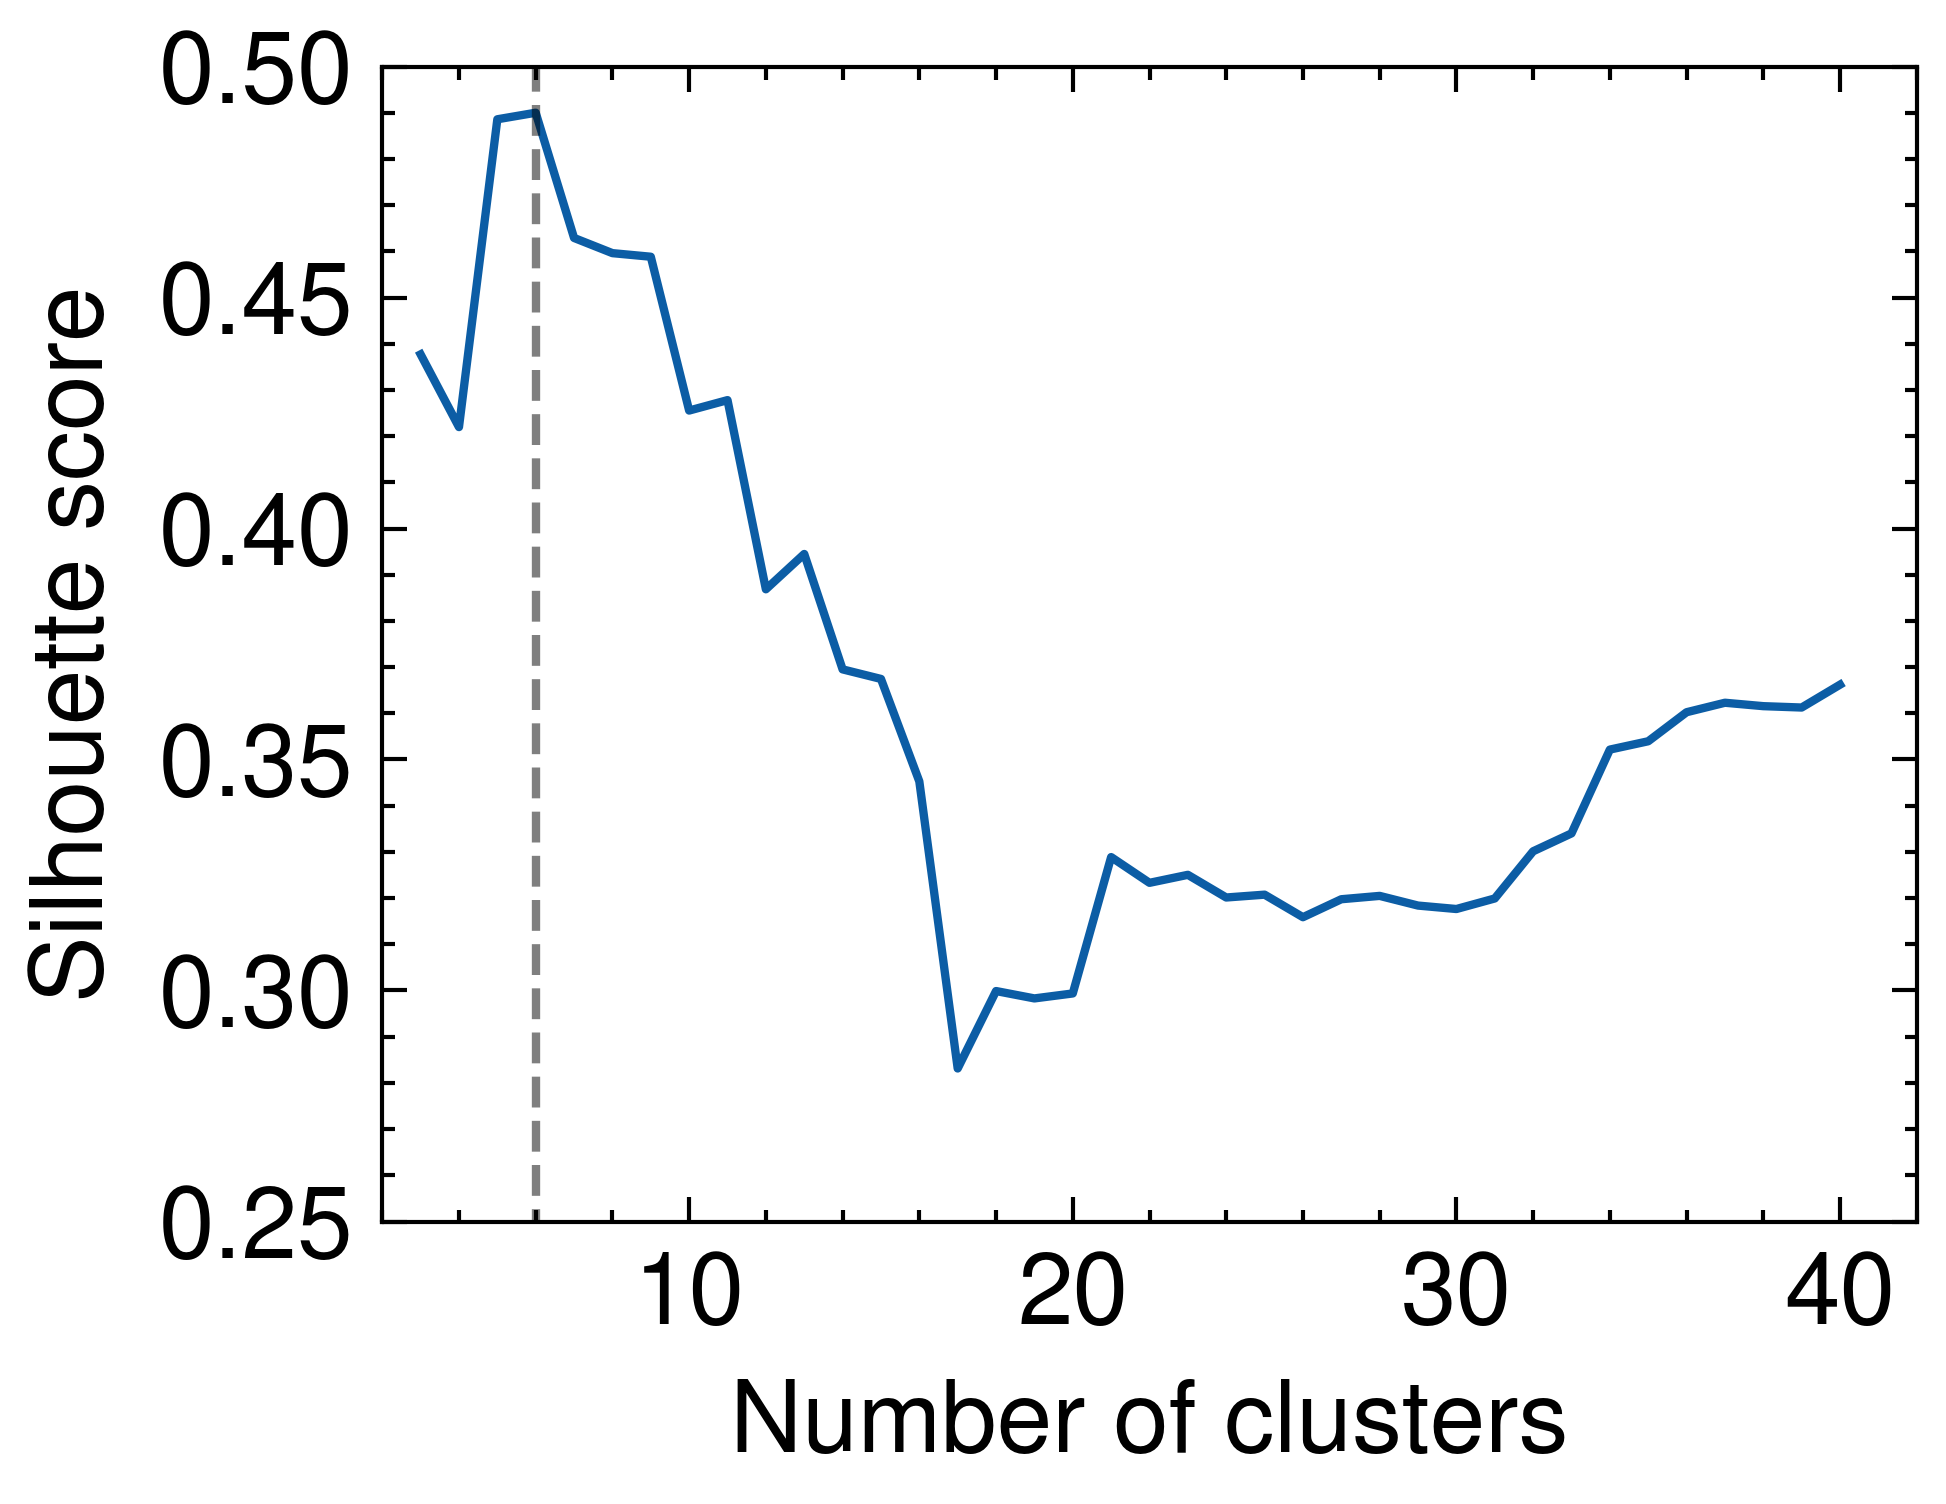

In [13]:
fig, ax = plt.subplots(clear=True)
sns.lineplot(x=np.arange(3, max_clusters + 1), y=silhouette, ax=ax)
ax.plot([optimal_k, optimal_k], [0, 1], linestyle='--', color='black', alpha=0.5)
ax.set_ylim([0.25, 0.5])
ax.set_xlim([2, max_clusters + 2])
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Silhouette score')
print(optimal_k)

In [14]:
aggl = AgglomerativeClustering(n_clusters=optimal_k, metric='euclidean', linkage='average', compute_distances=True)
aggl.fit(X)
cluster_results.loc[1] = ['Agglomerative', True, optimal_k, np.max(silhouette), davies_bouldin_score(X, aggl.labels_), calinski_harabasz_score(X, aggl.labels_)]
cluster_results

,model,mds,optimal_k,ss,db,ch
0,Agglomerative,False,11,0.249003,1.275258,433.649021
1,Agglomerative,True,6,0.489996,0.750460,2665.416704


#### Dendrogram

In [21]:
n_clusters = optimal_k
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42, n_jobs=-1)
X = mds.fit_transform(D)
model = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='average', compute_distances=True)
model.fit(X)
agg_clusters = pd.Series(model.labels_, index=ids)

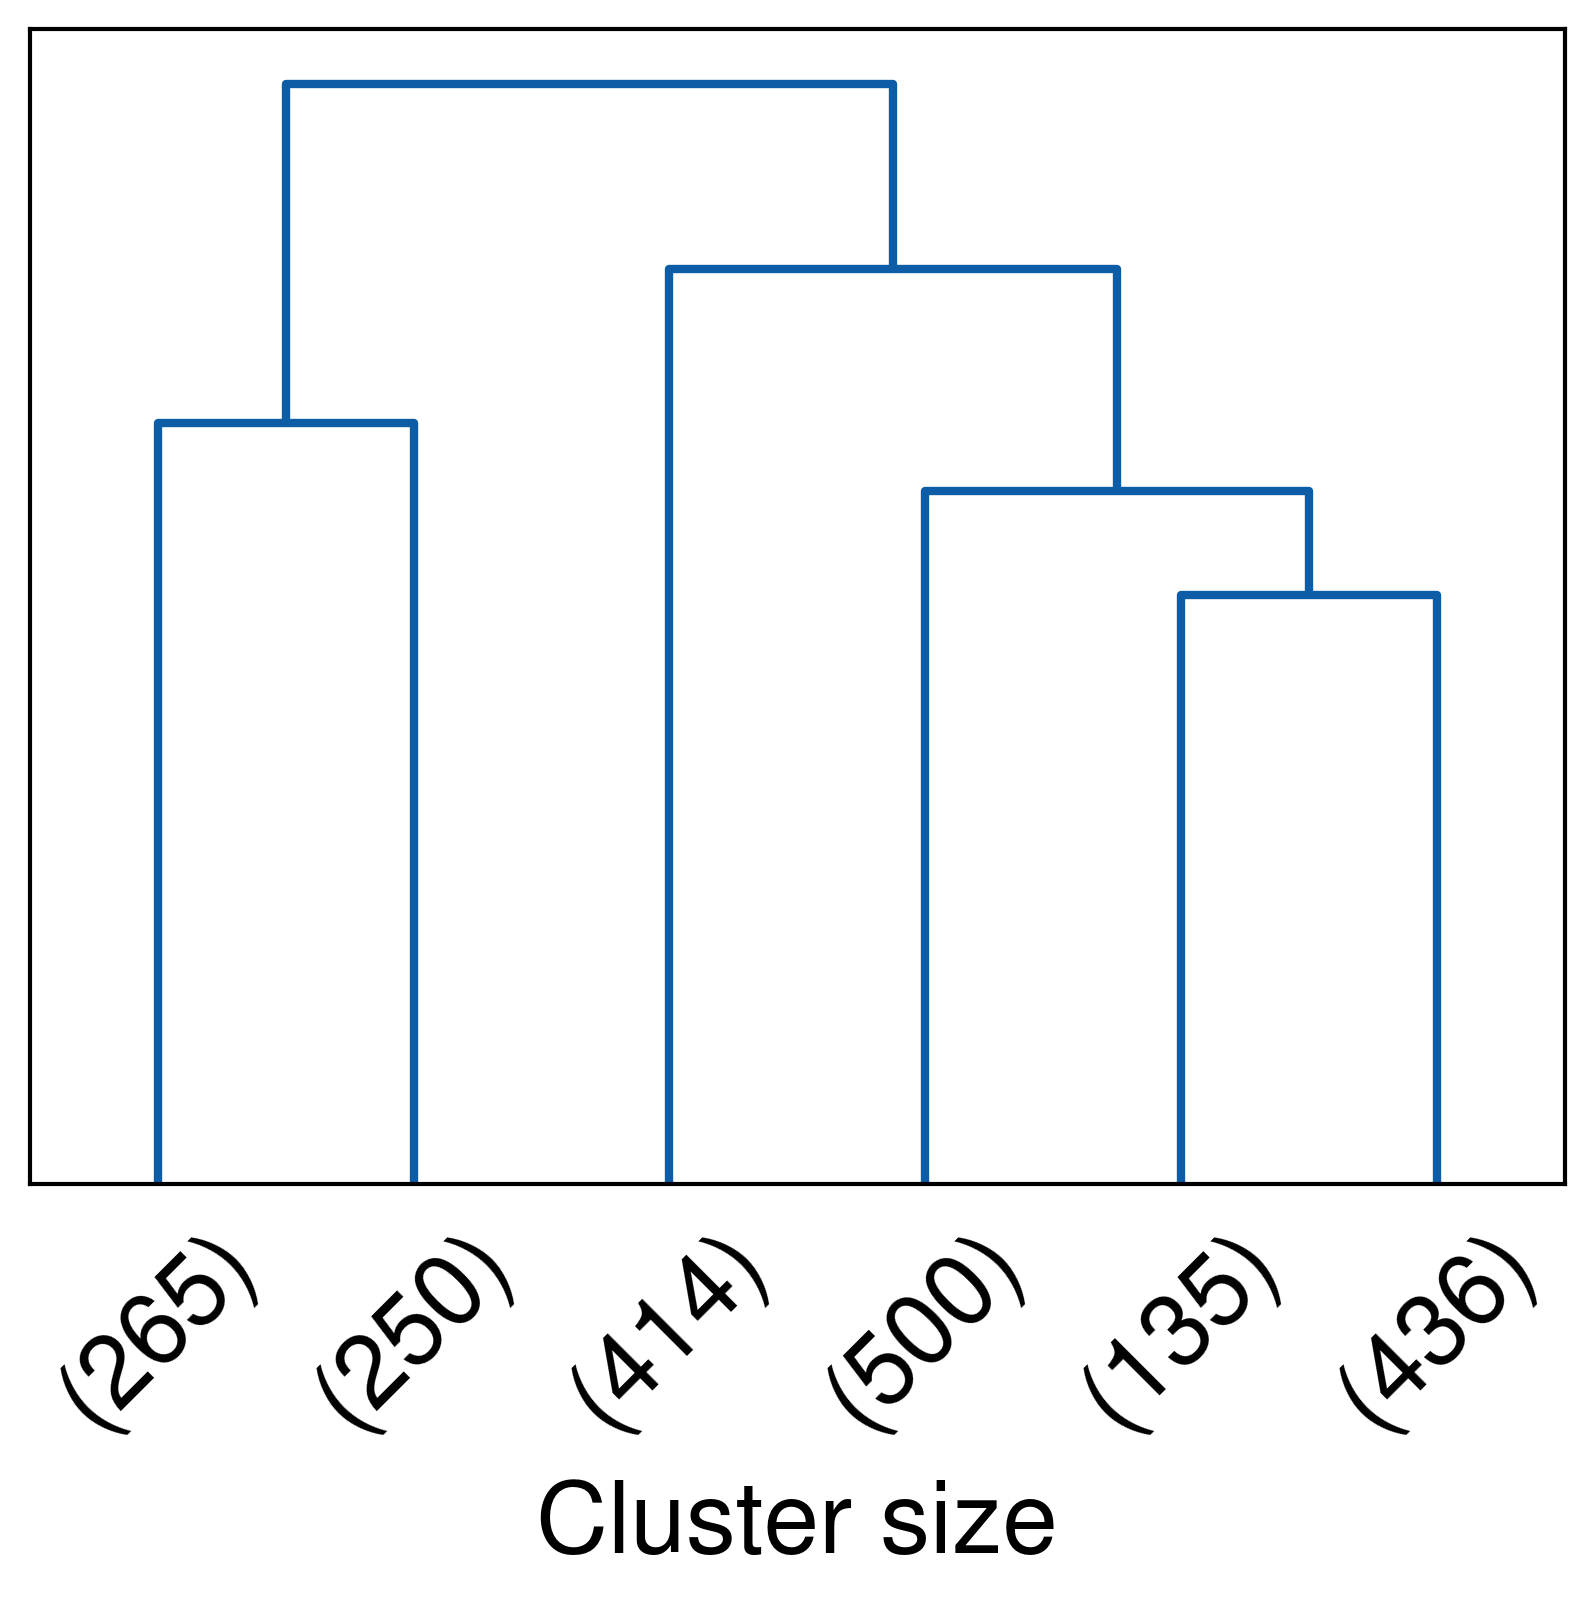

In [23]:
fig, ax = plt.subplots()
plot_dendrogram(model, labels=ids, p=int(n_clusters), truncate_mode='lastp', leaf_rotation=45, color_threshold=0)
ax.set_xlabel('Cluster size')
ax.yaxis.set_major_locator(ticker.FixedLocator([]))
ax.yaxis.set_minor_locator(ticker.NullLocator())
ax.xaxis.set_minor_locator(ticker.NullLocator())

#### Medoid (most representative structure within each cluster)
Results saved to csv so we can inspect the individual structures later in PyMOL. 

In [51]:
# Representative structure of each cluster + number of members, using the distance matrix as input 
medoids = get_medoid(model, D, ids)
medoids = medoids.merge(agg_clusters.value_counts(), left_on='cluster', right_index=True)
print(medoids)

   cluster  index  medoid  count
0        0   1342  sd_065    250
1        1   1475  sd_044    265
2        2   1535  dd_496    135
3        3   1540  dd_281    436
4        4    940  dr_186    500
5        5      2  sr_177    414


### K-Medoids

#### Determining number of clusters based on the the silhouette score

##### No dimensionality reduction and precomputed distance matrix

In [25]:
# Bundled ensembles
D, ids = load_bundle()
max_clusters = 20
optimal_k, silhouette = find_optimal_k_silhouette(D, KMedoids, max_clusters=max_clusters, model_name='KMedoids', verbose=False, metric='precomputed', method='pam', init='k-medoids++', random_state=42)
print(optimal_k)

19


(0.2, 0.3)

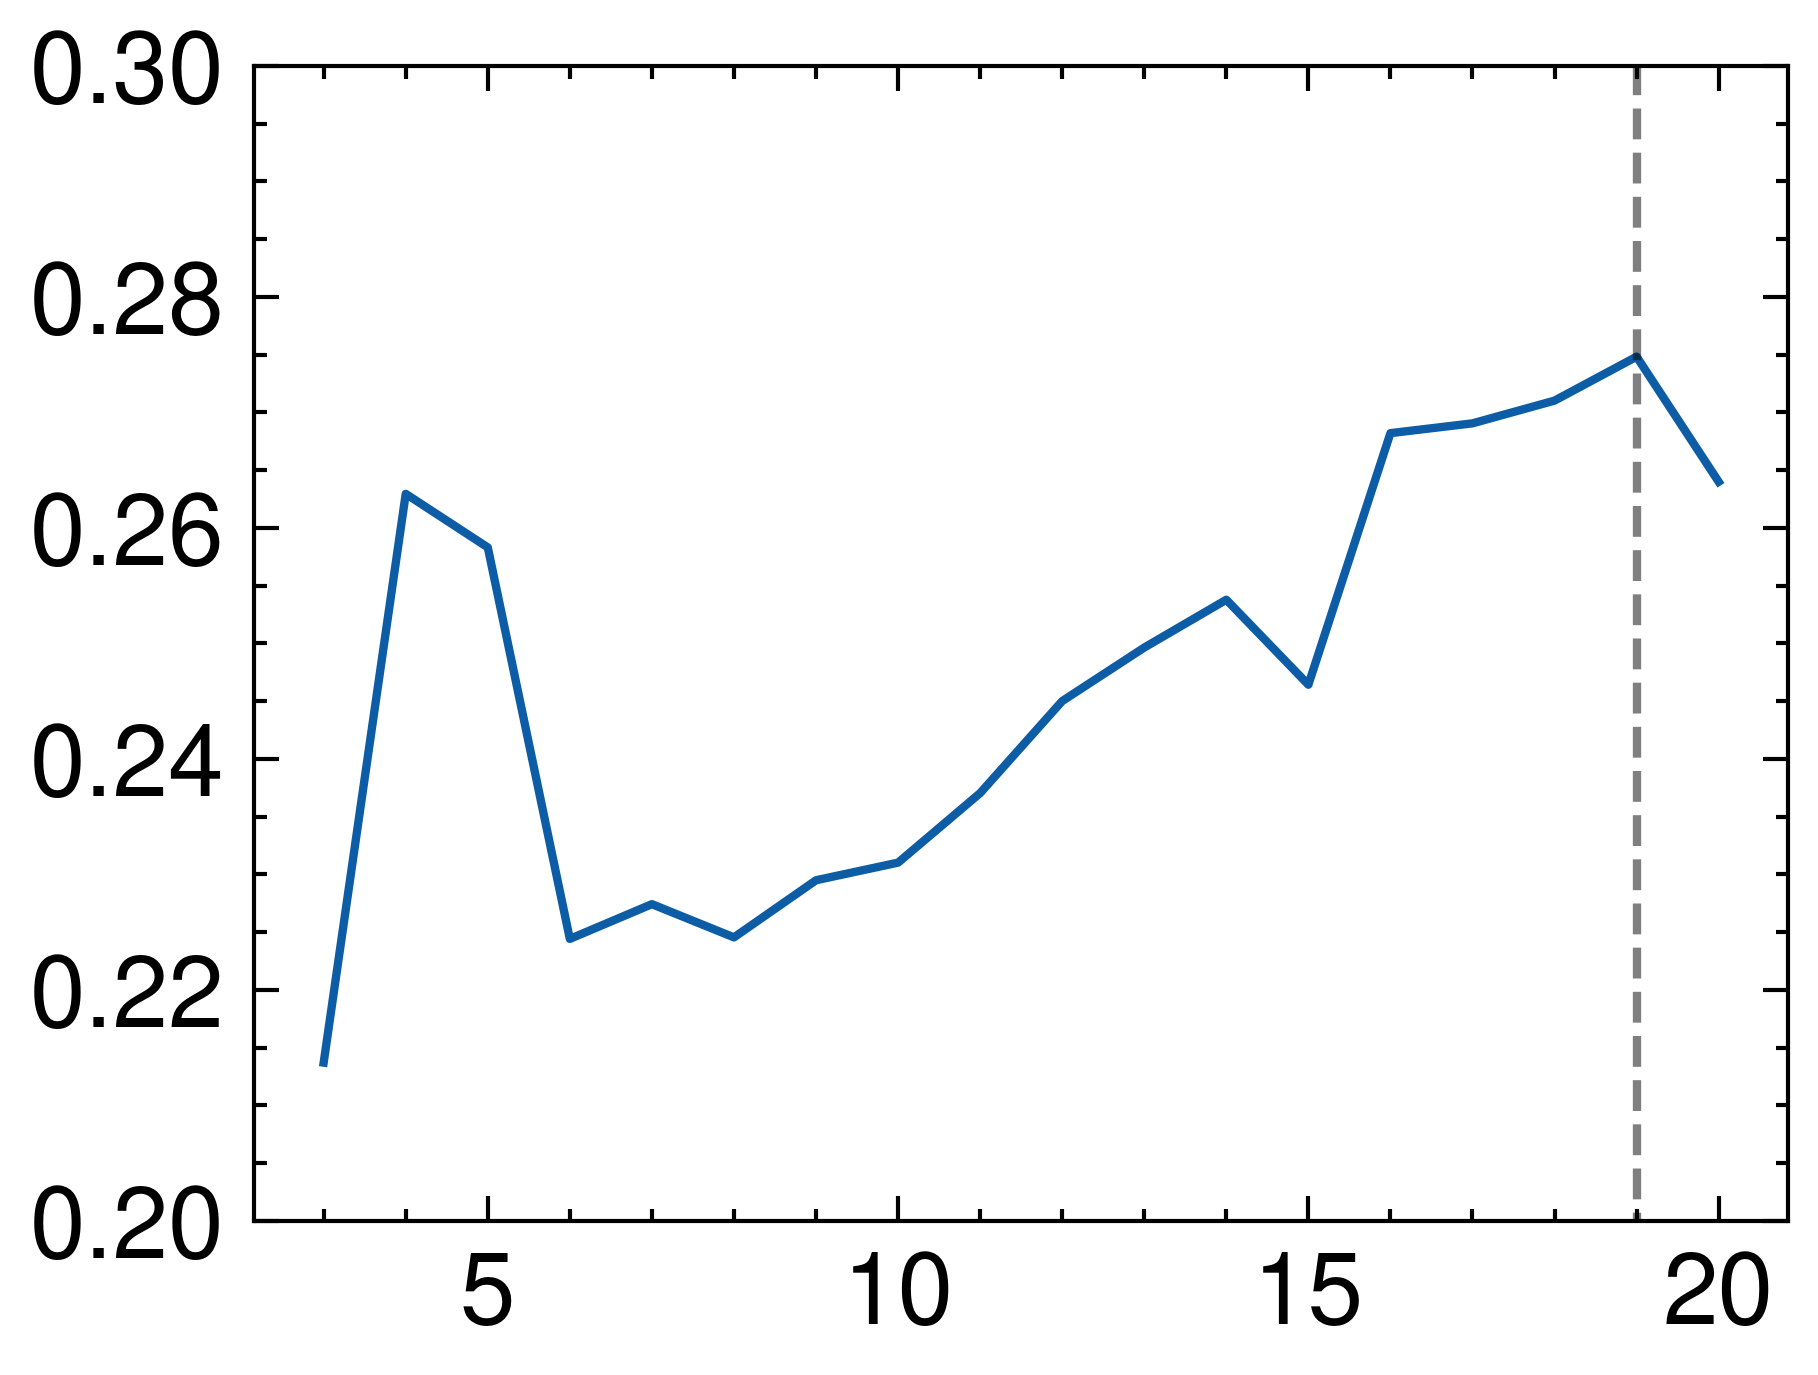

In [30]:
fig, ax = plt.subplots(clear=True)
sns.lineplot(x=np.arange(3, max_clusters + 1), y=silhouette, ax=ax)
ax.plot([optimal_k, optimal_k], [0, 1], linestyle='--', color='black', alpha=0.5)
ax.set_ylim([0.2, 0.3])

In [32]:
kmedoids = KMedoids(n_clusters=optimal_k, metric='precomputed', method='pam', init='k-medoids++', random_state=42)
kmedoids.fit(D)
cluster_results.loc[2] = ['KMedoids', False, optimal_k, np.max(silhouette), davies_bouldin_score(D, kmedoids.labels_), calinski_harabasz_score(D, kmedoids.labels_)]
cluster_results

,model,mds,optimal_k,ss,db,ch
0,Agglomerative,False,11,0.249003,1.275258,433.649021
1,Agglomerative,True,6,0.489996,0.750460,2665.416704
2,KMedoids,False,19,0.274820,1.384785,924.173147


##### With dimensionality reduction

In [33]:
# Bundled ensembles
D, ids = load_bundle()
max_clusters = 20
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42, n_jobs=-1)
X = mds.fit_transform(D)
optimal_k, silhouette = find_optimal_k_silhouette(X, KMedoids, max_clusters=max_clusters, model_name='KMedoids', verbose=False, metric='euclidean', method='pam', init='k-medoids++', random_state=42)

(0.4, 0.52)

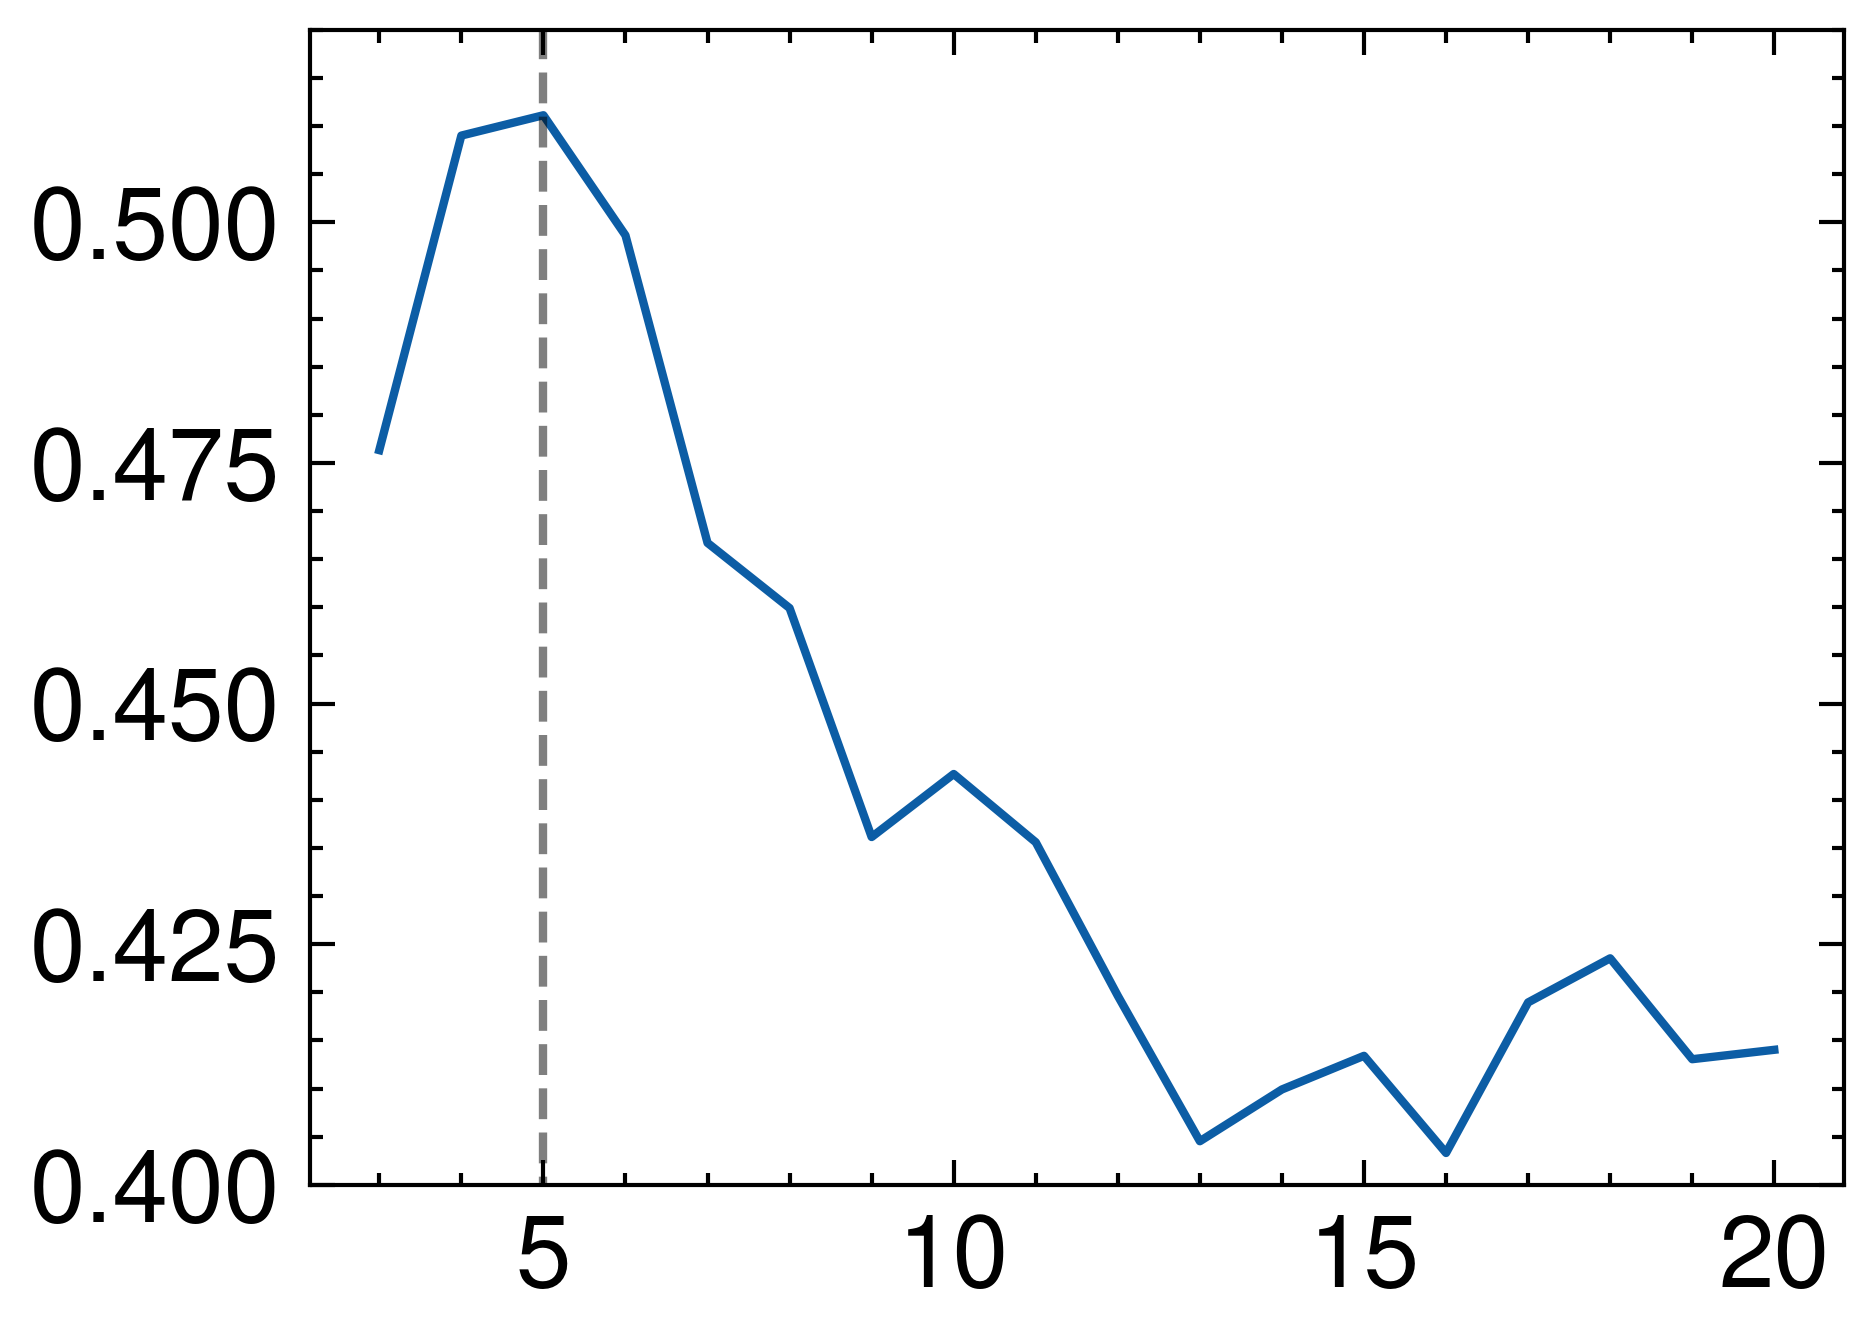

In [34]:
fig, ax = plt.subplots(clear=True)
sns.lineplot(x=np.arange(3, max_clusters + 1), y=silhouette, ax=ax)
ax.plot([optimal_k, optimal_k], [0, 1], linestyle='--', color='black', alpha=0.5)
ax.set_ylim([0.4, 0.52])

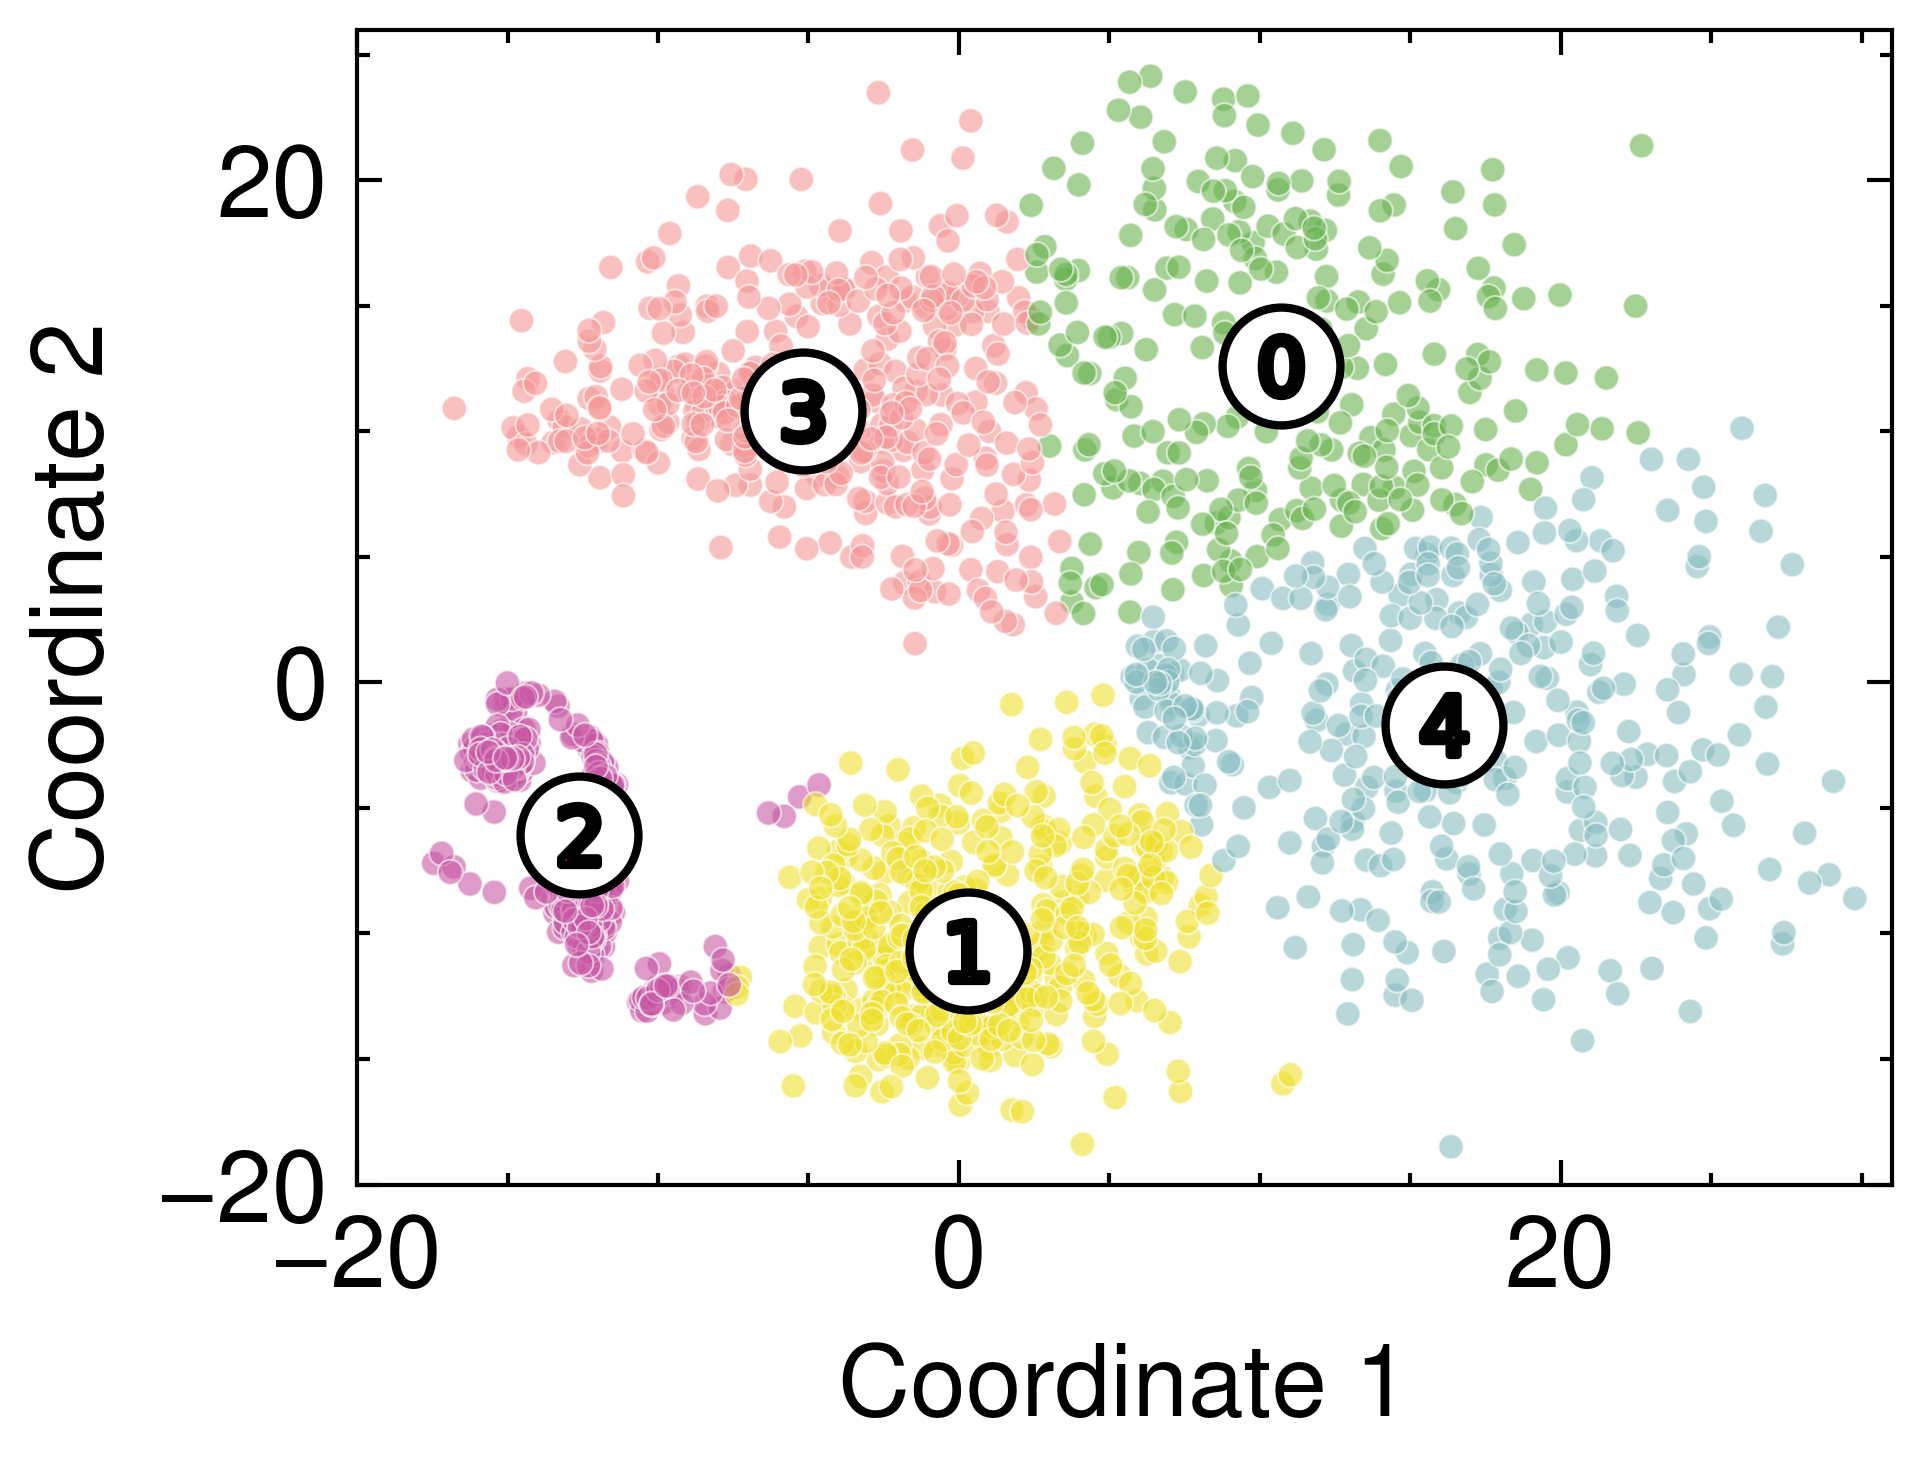

In [35]:
kmedoids = KMedoids(n_clusters=optimal_k, metric='euclidean', method='pam', init='k-medoids++', random_state=42)
kmedoids.fit(X)
ax = plot_clusters(X, kmedoids.labels_, centers=kmedoids.cluster_centers_)
ax.set_xlim([-20, 31])
ax.set_ylim([-20, 26])
ax.xaxis.set_major_locator(ticker.FixedLocator([-20, 0, 20]))
ax.yaxis.set_major_locator(ticker.FixedLocator([-20, 0, 20]))
plt.savefig(f'{save_dir}kmedoids_clusters.pdf', dpi=600, bbox_inches='tight')
kmedoids_df = pd.Series(kmedoids.labels_, index=ids)
cluster_results.loc[3] = ['KMedoids', True, optimal_k, np.max(silhouette), davies_bouldin_score(X, kmedoids.labels_), calinski_harabasz_score(X, kmedoids.labels_)]

In [36]:
cluster_results

,model,mds,optimal_k,ss,db,ch
0,Agglomerative,False,11,0.249003,1.275258,433.649021
1,Agglomerative,True,6,0.489996,0.750460,2665.416704
2,KMedoids,False,19,0.274820,1.384785,924.173147
3,KMedoids,True,5,0.511128,0.733978,2901.868240


In [37]:
pct_elements = kmedoids_df.value_counts() / 2000 * 100
print(pct_elements)

2    25.05
1    22.45
3    22.30
4    16.85
0    13.35
Name: count, dtype: float64


In [38]:
# Cluster 2 is mostly deep recycle elements 
label_2 = kmedoids_df[kmedoids_df == 2].index.str.startswith('dr').astype(int).sum()
print(label_2)

# Cluster 1 is mostly deep dropout elements
label_1 = kmedoids_df[kmedoids_df == 1].index.str.startswith('dd').astype(int).sum()
print(label_1)

# Cluster 3 is mostly shallow recycle elements
label_3 = kmedoids_df[kmedoids_df == 3].index.str.startswith('sr').astype(int).sum()
print(label_3)

# Clusters 0 and 4 are mostly shallow dropout elements
label_4 = kmedoids_df[kmedoids_df == 4].index.str.startswith('sd').astype(int).sum()
print(label_4)

label_0 = kmedoids_df[kmedoids_df == 0].index.str.startswith('sd').astype(int).sum()
print(label_0)

497
439
441
261
234


In [39]:
kmedoids_df.value_counts()

2    501
1    449
3    446
4    337
0    267
Name: count, dtype: int64

In [51]:
center_indices = [np.argmin(np.linalg.norm(X - center, axis=1)) for center in kmedoids.cluster_centers_]
print(X[center_indices])
print(X[center_indices] == kmedoids.cluster_centers_)

[[ 10.70499102  12.58058187]
 [  0.31709538 -10.69192184]
 [-12.61445756  -6.0983472 ]
 [ -5.19366791  10.7967085 ]
 [ 16.12404876  -1.69371484]]
[[ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]]


In [50]:
ids[center_indices]

array(['sd_044', 'dd_297', 'dr_155', 'sr_311', 'sd_333'], dtype='<U6')

### More "complex" clustering methods 
- HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise)
- Spectral clustering 

These achieve awful performance compared to the simple k-means!

In [40]:
D, ids = load_bundle()
np.random.seed(42)

#### Optimal $k$ by using the distance matrix or affinity matrix directly.

In [ ]:
# HDBSCAN
optimal_k_hdbscan, silhouette_hdbscan = find_optimal_k_silhouette(D.copy(), model=HDBSCAN, model_name='hdbscan', verbose=False, metric='precomputed', allow_single_cluster=False)
print(optimal_k_hdbscan, silhouette_hdbscan.max())
# Note: in the case of hdbscan optimal_k is the min number of elements required to form a cluster 

170 0.21794696369857844


In [43]:
hdbscan = HDBSCAN(min_cluster_size=optimal_k_hdbscan, metric='precomputed', allow_single_cluster=False)
hdbscan.fit(D)
cluster_results.loc[4] = ['HDBSCAN', False, len(np.unique(hdbscan.labels_)) - 1, silhouette_hdbscan.max(), davies_bouldin_score(D, hdbscan.labels_), calinski_harabasz_score(D, hdbscan.labels_)]
print(cluster_results)

           model    mds  optimal_k        ss        db           ch
0  Agglomerative  False         11  0.249003  1.275258   433.649021
1  Agglomerative   True          6  0.489996  0.750460  2665.416704
2       KMedoids  False         19  0.274820  1.384785   924.173147
3       KMedoids   True          5  0.511128  0.733978  2901.868240
4        HDBSCAN  False          2  0.217947  0.884855  1704.713844


In [44]:
# Spectral Clustering 
delta = 15 
D, ids = load_bundle()
max_clusters = 20
# Converting distance matrix into affinity matrix 
affinity_matrix = np.exp(- D.copy() ** 2 / (2.0 * delta ** 2))
optimal_k_spectral, silhouette_spectral = find_optimal_k_silhouette(affinity_matrix.copy(), model=SpectralClustering, max_clusters=max_clusters, model_name='spectral', verbose=False, affinity='precomputed', eigen_solver='arpack', assign_labels="cluster_qr")
print(optimal_k_spectral, silhouette_spectral.max())

5 0.3837210701471093


In [45]:
spectral = SpectralClustering(n_clusters=optimal_k_spectral, affinity='precomputed', eigen_solver='arpack', assign_labels="cluster_qr")
spectral.fit(affinity_matrix)
cluster_results.loc[5] = ['Spectral', False, optimal_k_spectral, silhouette_spectral.max(), davies_bouldin_score(affinity_matrix, spectral.labels_), calinski_harabasz_score(affinity_matrix, spectral.labels_)]
cluster_results

,model,mds,optimal_k,ss,db,ch
0,Agglomerative,False,11,0.249003,1.275258,433.649021
1,Agglomerative,True,6,0.489996,0.750460,2665.416704
2,KMedoids,False,19,0.274820,1.384785,924.173147
3,KMedoids,True,5,0.511128,0.733978,2901.868240
4,HDBSCAN,False,2,0.217947,0.884855,1704.713844
5,Spectral,False,5,0.383721,1.540526,1695.960114


#### Clustering after dimensionality reduction

In [46]:
D, ids = load_bundle()
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42, n_jobs=-1)
X_distance = mds.fit_transform(D.copy())
X_affinity = np.exp(- X_distance.copy() ** 2 / (2.0 * delta ** 2))

In [47]:
optimal_k_hdbscan_red, silhouette_hdbscan_red = find_optimal_k_silhouette(X_distance.copy(), model=HDBSCAN, model_name='hdbscan', verbose=False, metric='euclidean', allow_single_cluster=False)
print(optimal_k_hdbscan_red, silhouette_hdbscan_red.max())

193 0.38218876285433045


In [48]:
hdbscan = HDBSCAN(min_cluster_size=optimal_k_hdbscan_red, metric='euclidean', allow_single_cluster=False)
hdbscan.fit(X_distance)
cluster_results.loc[6] = ['HDBSCAN', True, len(np.unique(hdbscan.labels_)) - 1, silhouette_hdbscan_red.max(), davies_bouldin_score(X_distance, hdbscan.labels_), calinski_harabasz_score(X_distance, hdbscan.labels_)]
print(cluster_results)

           model    mds  optimal_k        ss        db           ch
0  Agglomerative  False         11  0.249003  1.275258   433.649021
1  Agglomerative   True          6  0.489996  0.750460  2665.416704
2       KMedoids  False         19  0.274820  1.384785   924.173147
3       KMedoids   True          5  0.511128  0.733978  2901.868240
4        HDBSCAN  False          2  0.217947  0.884855  1704.713844
5       Spectral  False          5  0.383721  1.540526  1695.960114
6        HDBSCAN   True          2  0.382189  0.924843  1266.386420


In [49]:
optimal_k_spectral_red, silhouette_spectral_red = find_optimal_k_silhouette(X_affinity.copy(), model=SpectralClustering, model_name='spectral', max_clusters=20, verbose=False, affinity='nearest_neighbors', eigen_solver='arpack', assign_labels="cluster_qr")
print(optimal_k_spectral_red, silhouette_spectral_red.max())

3 0.403953006401528


In [50]:
sc = SpectralClustering(n_clusters=optimal_k_spectral_red, affinity='nearest_neighbors', eigen_solver='arpack', assign_labels="cluster_qr", random_state=42)
sc.fit(X_affinity)
cluster_results.loc[7] = ['Spectral', True, optimal_k_spectral_red, silhouette_spectral_red.max(), davies_bouldin_score(X_affinity, sc.labels_), calinski_harabasz_score(X_affinity, sc.labels_)]
cluster_results

,model,mds,optimal_k,ss,db,ch
0,Agglomerative,False,11,0.249003,1.275258,433.649021
1,Agglomerative,True,6,0.489996,0.750460,2665.416704
2,KMedoids,False,19,0.274820,1.384785,924.173147
3,KMedoids,True,5,0.511128,0.733978,2901.868240
4,HDBSCAN,False,2,0.217947,0.884855,1704.713844
5,Spectral,False,5,0.383721,1.540526,1695.960114
6,HDBSCAN,True,2,0.382189,0.924843,1266.386420
7,Spectral,True,3,0.403953,0.818308,1887.129889


In [46]:
cluster_results.to_csv('./results/cluster_results.csv', index=False, header=True)